# **PREPARATION**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
class Model(tf.keras.models.Sequential):
  def __init__(self):
    super().__init__()
    self.model = tf.keras.models.Sequential()

  def build(self):
    self.model.add(tf.keras.layers.Flatten(input_shape=(10, )))
    self.model.add(tf.keras.layers.Dense(300, activation= 'relu'))
    self.model.add(tf.keras.layers.Dense(150, activation= 'relu'))
    self.model.add(tf.keras.layers.Dense(50, activation= 'relu'))
    self.model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
    self.model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  def train(self, x_train, y_train, x_val, y_val, epochs = 100, batch_size = 32):
    self.history = self.model.fit(x_train, y_train, epochs= epochs, batch_size= batch_size, validation_data= (x_val, y_val))

  def evaluate(self, x_test, y_test):
    test_loss, test_acc = self.model.evaluate(x_test, y_test)
    print("Total loss: ", test_loss)
    print("Model accuracy: ", test_acc)

  def predict(self, X):
    return self.model.predict(X)
    
  def save(self, name= "model"):
    return self.model.save(f"{name}.h5")

In [ ]:
def checking_missing(dataframe):
  plt.title("Missing values")
  sns.heatmap(dataframe.isnull().sum().to_frame(), annot= True, fmt= 'd', cmap= 'Blues')
  plt.show()

In [ ]:
def categorical_plot(df, n_rows, n_cols, cols, fig_size=(2*7.5, 9.5)):
  fig, ax = plt.subplots(n_rows, n_cols, figsize= fig_size)
  for r in range(n_rows):
    for c in range(n_cols):
      i = r*n_cols+c
      if i < len(cols):
        ax_i = ax[r, c]
        sns.countplot(df, x = cols[i], hue = 'stroke', palette= 'Blues', ax= ax_i)
        for container in ax_i.containers:
          ax_i.bar_label(container) 
        ax_i.set_title(f"Stroke rate vs {cols[i]}")
        ax_i.legend(title= '', loc= 'upper right', labels = ['stroke', 'no stroke'])
  ax.flat[-1].set_visible(False)
  plt.tight_layout()

In [ ]:
def numerical_plot(df, n_rows, n_cols, cols, bin, fig_size=(2*7.5, 9.5)):
  fig, ax = plt.subplots(n_rows, n_cols, figsize= fig_size)
  for r in range(n_rows):
    for c in range(n_cols):
      i = r*n_cols+c
      if i < len(cols):
        ax_i = ax[r, c]
        sns.histplot(df, x = cols[i], hue = 'stroke', bins= bin, kde= True, ax= ax_i)
        ax_i.set_title(f"Stroke rate vs {cols[i]}")
        ax_i.legend(title= '', loc= 'upper right', labels = ['stroke', 'no stroke'])
  ax.flat[-1].set_visible(False)
  plt.tight_layout()

In [ ]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

In [ ]:
data = df.copy()

# **EDA**

**`DROP USELESS VALUE`**


> 'id' is useless value



In [ ]:
df.drop(['id'], axis= 1, inplace = True)

In [ ]:
ob_int_cols = df.select_dtypes(include=['object', 'int64']).columns.tolist()
num_cols = df.select_dtypes(include=['float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
#drop column "stroke" because it is target column
ob_int_cols.pop()

'stroke'

In [ ]:
ob_int_cols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


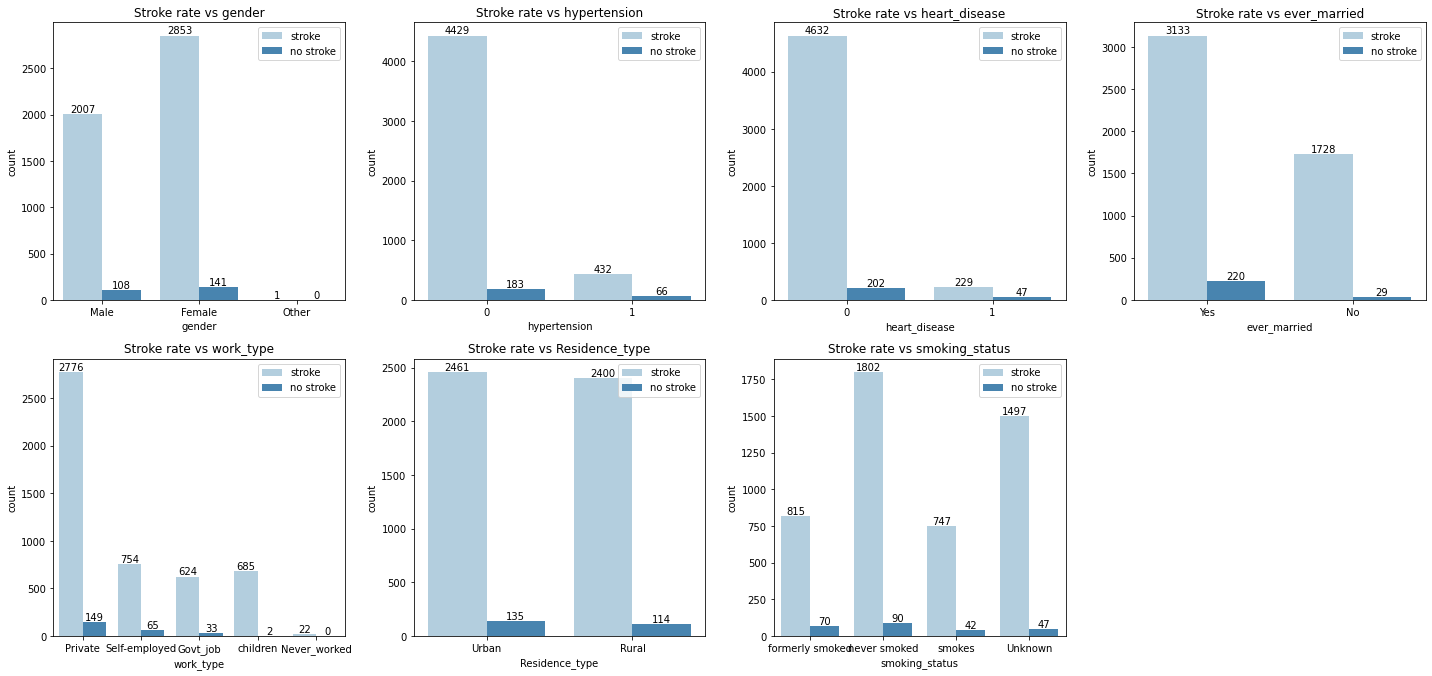

In [ ]:
categorical_plot(df, 2, 4, ob_int_cols, (20, 9.5))

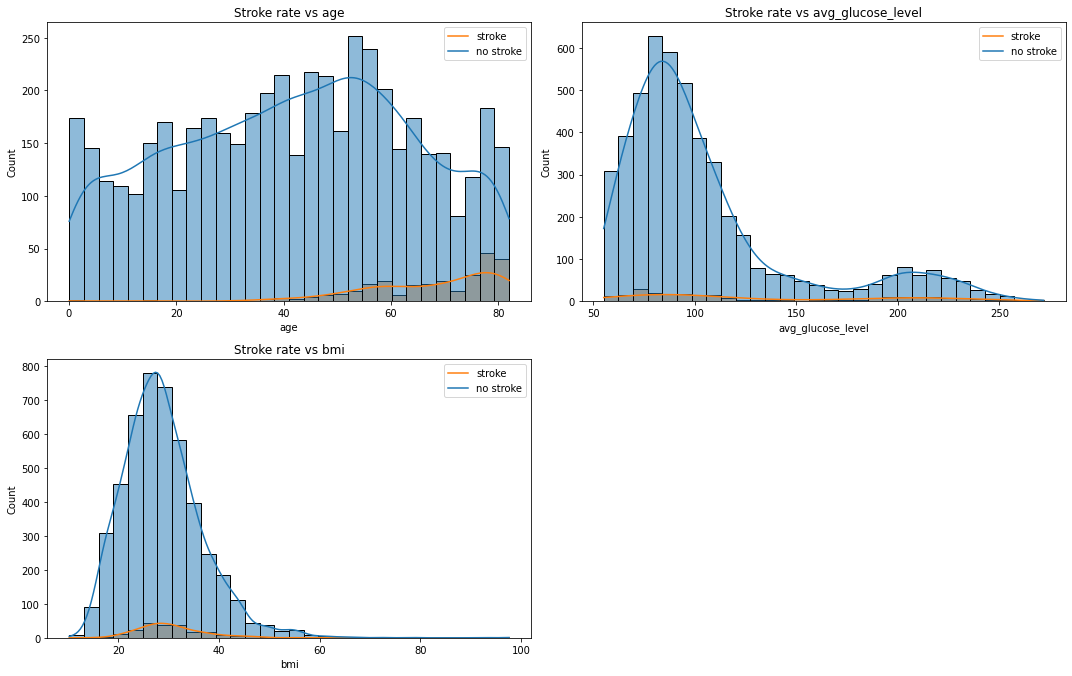

In [ ]:
numerical_plot(df, 2, 2, num_cols, 30)

# **PREPROCESSING & DATA WRANGLING**

**`CHECKING MISSING VALUES`**

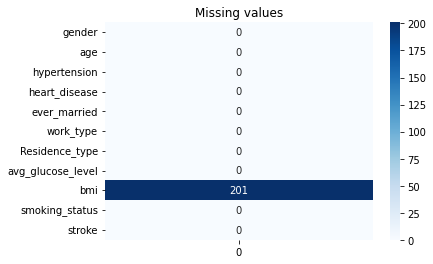

In [ ]:
checking_missing(df)

**`FILLING MISSING VALUES WITH MEAN`**

In [ ]:
bmi_by_age_avgglucose = df.groupby(['age', 'avg_glucose_level']).median()['stroke']

In [ ]:
bmi_by_age_avgglucose

age    avg_glucose_level
0.08   70.33                0.0
       139.67               0.0
0.16   69.79                0.0
       109.52               0.0
       114.71               0.0
                           ... 
82.00  227.28               0.0
       228.92               0.0
       229.58               0.0
       243.59               0.0
       253.16               0.0
Name: stroke, Length: 5091, dtype: float64

*As you can see, the median of stroke related to age and average glucose level is not suitable for fill in missing values, so i will try to fillna with the median of bmi*



In [ ]:
df['bmi'].fillna(df['bmi'].mean(), inplace= True)

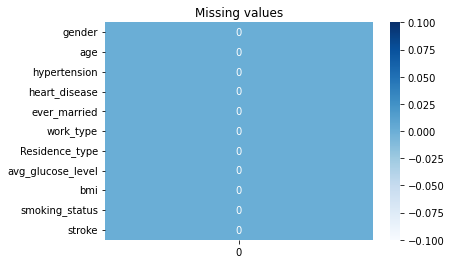

In [ ]:
checking_missing(df)

In [ ]:
#encoding string to float/int
le = LabelEncoder()

for col in cat_cols: 
  le.fit(df[col])
  df[col] = le.transform(df[col])

In [ ]:
#standalize numerical values
mm = MinMaxScaler()
mm.fit_transform(df[num_cols])

array([[0.81689453, 0.80126489, 0.30126002],
       [0.74365234, 0.67902317, 0.21298095],
       [0.97558594, 0.23451205, 0.25429553],
       ...,
       [0.42626953, 0.12865848, 0.2325315 ],
       [0.62158203, 0.51320284, 0.17525773],
       [0.53613281, 0.13922999, 0.18213058]])

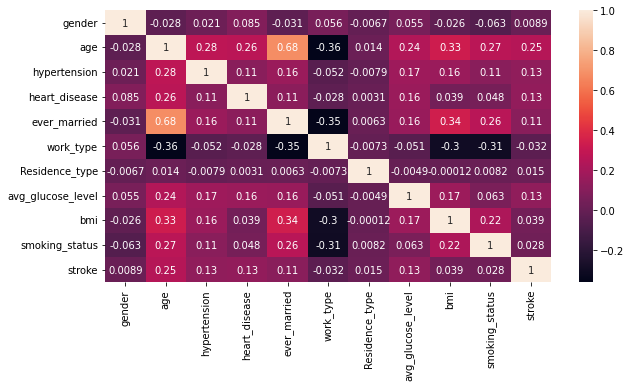

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

# **TRAINING MODEL**

In [ ]:
X = df.iloc[:,:10]
Y = df.iloc[:,10:]

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size= 0.2)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size= 0.3)

In [ ]:
X_train_tf = tf.convert_to_tensor(X_train)
X_test_tf = tf.convert_to_tensor(X_test)
X_valid_tf = tf.convert_to_tensor(X_valid)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)
y_valid_tf = tf.convert_to_tensor(y_valid)

In [ ]:
model = Model()
model.build()

In [ ]:
history = model.train(X_train_tf, y_train_tf, X_valid_tf, y_valid_tf, epochs = 100, batch_size= 64)

Epoch 1/100
45/45 [==============================] - 1s 8ms/step - loss: 0.4981 - accuracy: 0.9238 - val_loss: 0.2432 - val_accuracy: 0.9527
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2197 - accuracy: 0.9465 - val_loss: 0.1767 - val_accuracy: 0.9527
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 0.2017 - accuracy: 0.9472 - val_loss: 0.1904 - val_accuracy: 0.9527
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.2067 - accuracy: 0.9462 - val_loss: 0.1814 - val_accuracy: 0.9527
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2003 - accuracy: 0.9462 - val_loss: 0.1794 - val_accuracy: 0.9527
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.2085 - accuracy: 0.9444 - val_loss: 0.2000 - val_accuracy: 0.9527
Epoch 7/100
45/45 [==============================] - 0s 5ms/step - loss: 0.2008 - accuracy: 0.9458 - val_loss: 0.2107 - val_accuracy: 0.9527
Epoch 8/100
4

In [ ]:
model.evaluate(X_test_tf, y_test_tf)

32/32 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9540
Total loss:  0.1562270075082779
Model accuracy:  0.9540117383003235


In [ ]:
model.save("model")